# Imports

This section contains all the installs and imports needed to run the code. 

In [1]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.1 MB/s eta 0:00:00a 0:00:01


In [1]:
from math import sqrt
import numpy as np
from numpy import load, asarray, zeros, ones, savez_compressed
from numpy.random import randn, randint
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, LeakyReLU, Layer, Add
from keras.constraints import max_norm
from keras.initializers import RandomNormal
import mtcnn
from mtcnn.mtcnn import MTCNN
from keras import backend
import matplotlib.pyplot as plt
import cv2
import os
from os import listdir
from PIL import Image
import cv2

In [2]:
learning_rate = 0.001
beta1 = 0.0
beta2 = 0.99
epsilon = 1e-8
adam_config = {'learning_rate': learning_rate, 'beta_1': beta1, 'beta_2': beta2, 'epsilon': epsilon}

# Creating the model

In [3]:
# pixel-wise feature vector normalization layer
class PixelNormalization(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)
 
    # perform the operation
    def call(self, inputs):
        # computing pixel values
        values = inputs**2.0
        mean_values = backend.mean(values, axis=-1, keepdims=True)
        mean_values += 1.0e-8
        l2 = backend.sqrt(mean_values)
        normalized = inputs / l2
        return normalized
 
    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        return input_shape

In [4]:
# mini-batch standard deviation layer
class MinibatchStdev(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)
 
    # perform the operation
    def call(self, inputs):
        mean = backend.mean(inputs, axis=0, keepdims=True)
        squ_diffs = backend.square(inputs - mean)
        mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
        mean_sq_diff += 1e-8
        stdev = backend.sqrt(mean_sq_diff)
        
        mean_pix = backend.mean(stdev, keepdims=True)
        shape = backend.shape(inputs)
        output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        
        combined = backend.concatenate([inputs, output], axis=-1)
        return combined
 
    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 1
        return tuple(input_shape)

In [5]:
# weighted sum output
class WeightedSum(Add):
    # init with default value
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = backend.variable(alpha, name='ws_alpha')
 
    # output a weighted sum of inputs
    def _merge_function(self, inputs):
        # only supports a weighted sum of two inputs
        assert (len(inputs) == 2)
        # ((1-a) * input1) + (a * input2)
        output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
        return output

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

# Model helper functions

In [6]:
import tqdm
# load dataset
def load_images(directory):
    faces = list()
    for filename in tqdm.tqdm(listdir(directory)):
        face = Image.open(directory + filename)
        face = asarray(face)
        faces.append(face)
    
    faces = asarray(faces)
    faces = faces.astype('float32')
    faces = (faces - 127.5) / 127.5
    
    return faces
 
# select real samples
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input, verbose=0)
    y = -ones((n_samples, 1))
    return X, y
 
# update the alpha value on each instance of WeightedSum
def update_fadein(models, step, n_steps):
    alpha = step / float(n_steps - 1)
    for model in models:
        for layer in model.layers:
            if isinstance(layer, WeightedSum):
                backend.set_value(layer.alpha, alpha)
                
# scale images to preferred size
def scale_dataset(images, new_shape):
    images_list = list()
    for image in images:
        new_image = resize(image, new_shape, 0)
        images_list.append(new_image)
    return asarray(images_list)

In [7]:
# Create a equalized learning rate layer that inherits from the Conv2D layer
class EqualizedConv2D(Conv2D):
    def __init__(self, *args, **kwargs):
        kwargs['kernel_initializer'] = kwargs.get('kernel_initializer', RandomNormal(0, 1))
        super(EqualizedConv2D, self).__init__(*args, **kwargs)
 
    def build(self, input_shape):
        super(EqualizedConv2D, self).build(input_shape)
        input_channels = input_shape[-1]
        kernel_size = self.kernel_size[0]
        self.lr_multiplier = (2 / (input_channels * (kernel_size ** 2))) ** 0.5
 
    # apply the learning rate multiplier
    def call(self, inputs):
        # Scale the weights without permanently modifying them
        scaled_weights = self.lr_multiplier * self.kernel
        outputs = self.convolution_op(inputs, scaled_weights)
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs
    
# Create a equalized learning rate layer that inherits from the Dense layer
class EqualizedDense(Dense):
    def __init__(self, *args, **kwargs):
        kwargs['kernel_initializer'] = kwargs.get('kernel_initializer', RandomNormal(0, 1))
        super(EqualizedDense, self).__init__(*args, **kwargs)
 
    def build(self, input_shape):
        super(EqualizedDense, self).build(input_shape)
        input_channels = input_shape[-1]
        self.lr_multiplier = (2 / input_channels) ** 0.5
 
    # apply the learning rate multiplier
    def call(self, inputs):
        # Scale the weights without permanently modifying them
        scaled_weights = self.lr_multiplier * self.kernel
        outputs = tf.matmul(inputs, scaled_weights)
        if self.use_bias:
            outputs = backend.bias_add(outputs, self.bias)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

# Model creation

In [8]:
# adding a generator block
def add_generator_block(old_model, filter_count, channels):
    block_end = old_model.layers[-2].output
    
    # upsample, and define new block
    upsampling = UpSampling2D()(block_end)
    g = EqualizedConv2D(filter_count, (3,3), padding='same')(upsampling)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    g = EqualizedConv2D(filter_count, (3,3), padding='same')(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    
    out_image = EqualizedConv2D(channels, (1,1), padding='same')(g)
    model1 = Model(old_model.input, out_image)
    out_old = old_model.layers[-1]
    out_image2 = out_old(upsampling)
    
    merged = WeightedSum()([out_image2, out_image])
    model2 = Model(old_model.input, merged)
    return [model1, model2]

In [9]:
# define generator models
def define_generator(latent_dim, n_blocks, initial_filter_count, in_dim=4, channels=3):
    model_list = list()
    
    in_latent = Input(shape=(latent_dim,))
    g = EqualizedDense(initial_filter_count * in_dim * in_dim)(in_latent)
    g = Reshape((in_dim, in_dim, initial_filter_count))(g)
    
    # conv 4x4, input block
    g = EqualizedConv2D(initial_filter_count, (4,4), padding='same')(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    
    # conv 3x3
    g = EqualizedConv2D(initial_filter_count, (3,3), padding='same')(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    
    # conv 1x1, output block
    out_image = EqualizedConv2D(channels, (1,1), padding='same')(g)
    model = Model(in_latent, out_image)
    model_list.append([model, model])
    
    for i in range(1, n_blocks):
        old_model = model_list[i - 1][0]
        models = add_generator_block(old_model, initial_filter_count, channels)# // (2 ** i))
        model_list.append(models)
        
    return model_list

In [10]:
# adding a discriminator block
def add_discriminator_block(old_model, filter_count, n_input_layers=3):
    in_shape = list(old_model.input.shape)
    
    # define new input shape as double the size
    input_shape = (in_shape[-2]*2, in_shape[-2]*2, in_shape[-1])
    in_image = Input(shape=input_shape)
    
    # define new input processing layer
    d = EqualizedConv2D(filter_count, (1,1), padding='same')(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    
    # define new block
    d = EqualizedConv2D(filter_count, (3, 3), padding='same')(d)
    d = LeakyReLU(alpha=0.2)(d)
    # d = Conv2D(filter_count * 2, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = EqualizedConv2D(filter_count, (3, 3), strides=2, padding='same')(d)
    d = LeakyReLU(alpha=0.2)(d)
    # d = AveragePooling2D()(d)
    block_new = d
    
    # skip the input, 1x1 and activation for the old model
    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)
    model1 = Model(in_image, d)
    
    model1.compile(loss=wasserstein_loss, optimizer=Adam(**adam_config))
    
    downsample = AveragePooling2D()(in_image)
    
    block_old = old_model.layers[1](downsample)
    block_old = old_model.layers[2](block_old)
    d = WeightedSum()([block_old, block_new])
    
    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)
        
    model2 = Model(in_image, d)
    
    model2.compile(loss=wasserstein_loss, optimizer=Adam(**adam_config))
    return [model1, model2]

In [11]:
# define the discriminator models for each image resolution
def define_discriminator(n_blocks, initial_filter_count, input_shape=(4,4,3)):
    model_list = list()
    in_image = Input(shape=input_shape)
    
    d = EqualizedConv2D(initial_filter_count, (1, 1), padding='same')(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    d = MinibatchStdev()(d)
    
    d = EqualizedConv2D(initial_filter_count, (3, 3), padding='same')(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = EqualizedConv2D(initial_filter_count, (4, 4), padding='same')(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Flatten()(d)
    out_class = EqualizedDense(1)(d)
    
    model = Model(in_image, out_class)
    model.compile(loss=wasserstein_loss, optimizer=Adam(**adam_config))
    model_list.append([model, model])
    
    for i in range(1, n_blocks):
        old_model = model_list[i - 1][0]
        models = add_discriminator_block(old_model, initial_filter_count)# / (2 ** i))
        model_list.append(models)
        
    return model_list

In [12]:
# define composite models for training generators via discriminators

def define_composite(discriminators, generators):
    model_list = list()
    # create composite models
    for i in range(len(discriminators)):
        g_models, d_models = generators[i], discriminators[i]
        # straight-through model
        d_models[0].trainable = False
        model1 = Sequential()
        model1.add(g_models[0])
        model1.add(d_models[0])
        model1.compile(loss=wasserstein_loss, optimizer=Adam(**adam_config))
        # fade-in model
        d_models[1].trainable = False
        model2 = Sequential()
        model2.add(g_models[1])
        model2.add(d_models[1])
        model2.compile(loss=wasserstein_loss, optimizer=Adam(**adam_config))
        # store
        model_list.append([model1, model2])
    return model_list

# Create training block

In [13]:
# train a generator and discriminator
def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, fadein, critic_steps):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    half_batch = int(n_batch / 2)
    d_loss1_avg = 0
    d_loss2_avg = 0
    g_loss_avg = 0
    
    for i in range(n_steps):
        # update alpha for all WeightedSum layers when fading in new blocks
        if fadein:
            update_fadein([g_model, d_model, gan_model], i, n_steps)
        
        # prepare real and fake samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        
        for _ in range(critic_steps):
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss1 = d_model.train_on_batch(X_real, y_real)
            d_loss2 = d_model.train_on_batch(X_fake, y_fake)
        
            d_loss1_avg += d_loss1/critic_steps
            d_loss2_avg += d_loss2/critic_steps
        
        # update the generator via the discriminator's error
        z_input = generate_latent_points(latent_dim, n_batch)
        y_real2 = ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(z_input, y_real2)
        g_loss_avg += g_loss
        
        if i % 100 == 0:
            print('Step:%d | Avg Loss: d_loss_real=%.3f, d_loss_fake=%.3f g=%.3f' % (i+1, d_loss1_avg/100, d_loss2_avg/100, g_loss_avg/100))
            d_loss1_avg = 0
            d_loss2_avg = 0
            g_loss_avg = 0
        
        if i % 1000 == 0:
            # Plot some samples
            X, _ = generate_fake_samples(g_model, latent_dim, 12)
            X = (X - X.min()) / (X.max() - X.min())
            
            plt.figure(figsize=(8, 3))
            for i in range(12):
                plt.subplot(2, 6, 1 + i)
                plt.axis('off')
                img_show = X[i]
                plt.imshow(img_show)
                
            plt.show()
            
        
# train the generator and discriminator
def train(g_models, d_models, gan_models, dataset, latent_dim, e_norm, e_fadein, n_batch, critic_steps=1):
    g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
    gen_shape = g_normal.output_shape
    scaled_data = scale_dataset(dataset, gen_shape[1:])
    print('Scaled Data', scaled_data.shape)

    # train normal or straight-through models
    train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[0], n_batch[0], False, critic_steps)
    summarize_performance('tuned', g_normal, d_normal, latent_dim)
    
    # process each level of growth
    for i in range(1, len(g_models)):
        # retrieve models for this level of growth
        [g_normal, g_fadein] = g_models[i]
        [d_normal, d_fadein] = d_models[i]
        [gan_normal, gan_fadein] = gan_models[i]
        
        # scale dataset to appropriate size
        gen_shape = g_normal.output_shape
        scaled_data = scale_dataset(dataset, gen_shape[1:])
        print('Scaled Data', scaled_data.shape)
        
        # train fade-in models for next level of growth
        train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, e_fadein[i], n_batch[i], True, critic_steps)
        summarize_performance('faded', g_fadein, d_fadein, latent_dim)
        
        # train normal or straight-through models
        train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[i], n_batch[i], False, critic_steps)
        summarize_performance('tuned', g_normal, d_normal, latent_dim)

In [14]:
# generate samples and save as a plot and save the model
def summarize_performance(status, g_model, d_model, latent_dim, n_samples=25):
    gen_shape = g_model.output_shape
    name = '%03dx%03d-%s' % (gen_shape[1], gen_shape[2], status)
    
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X - X.min()) / (X.max() - X.min())
    
    square = int(sqrt(n_samples))
    for i in range(n_samples):
        plt.subplot(square, square, 1 + i)
        plt.axis('off')
        img_show = X[i]
        plt.imshow(img_show)
        
    # save plot to file
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plot_filename = 'plots/plot_%s.png' % (name)
    plt.savefig(plot_filename)
    plt.close()
    
    if not os.path.exists('models'):
        os.makedirs('models')
    g_model_filename = 'models/model_%s.h5' % (name)
    g_model.save(g_model_filename)
    d_model_filename = 'models/d_model_%s.h5' % (name)
    d_model.save(d_model_filename)
    print('>Saved: %s, %s and %s' % (plot_filename, g_model_filename, d_model_filename))

# Run training

In [15]:
# Load all the images of face_images_32x32
directory = '/kaggle/input/ffhq-32x32/face_images_32x32/'
#dataset = load_images(directory)

#dataset = dataset[:, :, :, :3]

In [16]:
n_blocks = 4
initial_filter_count = 128
latent_dim = 40

d_models = define_discriminator(n_blocks, initial_filter_count, input_shape=(4,4,3))
g_models = define_generator(latent_dim, n_blocks, initial_filter_count, channels=3)
gan_models = define_composite(d_models, g_models)

n_batch = [16, 16, 16, 16]
n_epochs = [1, 2, 5, 10]



In [17]:
g_models[-1][0].summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 40)]              0         
                                                                 
 equalized_dense_1 (Equaliz  (None, 2048)              83968     
 edDense)                                                        
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 equalized_conv2d_12 (Equal  (None, 4, 4, 128)         262272    
 izedConv2D)                                                     
                                                                 
 pixel_normalization (Pixel  (None, 4, 4, 128)         0         
 Normalization)                                                  
                                                          

In [18]:
d_models[-1][0].summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 equalized_conv2d_9 (Equali  (None, 32, 32, 128)       512       
 zedConv2D)                                                      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 equalized_conv2d_10 (Equal  (None, 32, 32, 128)       147584    
 izedConv2D)                                                     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 equalized_conv2d_11 (Equal  (None, 16, 16, 128)       1475

Scaled Data (50000, 4, 4, 3)
Step:1 | Avg Loss: d_loss_real=0.007, d_loss_fake=0.010 g=-0.007


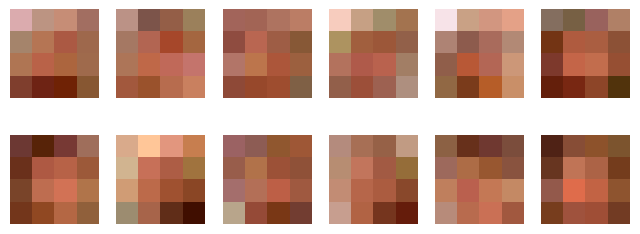

Step:101 | Avg Loss: d_loss_real=-1.363, d_loss_fake=1.484 g=-1.127
Step:201 | Avg Loss: d_loss_real=0.182, d_loss_fake=0.090 g=0.340
Step:301 | Avg Loss: d_loss_real=-1.216, d_loss_fake=1.391 g=-1.086
Step:401 | Avg Loss: d_loss_real=-0.526, d_loss_fake=0.496 g=-0.037
Step:501 | Avg Loss: d_loss_real=-0.608, d_loss_fake=0.796 g=-0.462
Step:601 | Avg Loss: d_loss_real=-1.180, d_loss_fake=1.212 g=-0.828
Step:701 | Avg Loss: d_loss_real=-1.111, d_loss_fake=1.226 g=-0.985
Step:801 | Avg Loss: d_loss_real=-0.650, d_loss_fake=0.825 g=-0.539
Step:901 | Avg Loss: d_loss_real=-0.877, d_loss_fake=0.884 g=-0.659
Step:1001 | Avg Loss: d_loss_real=-0.644, d_loss_fake=0.819 g=-0.650


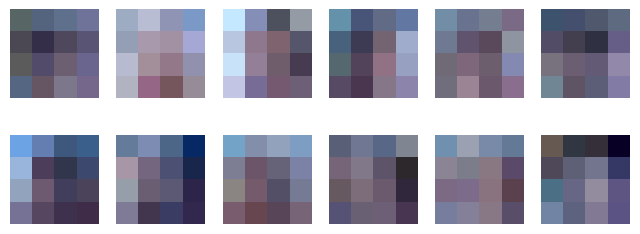

Step:1101 | Avg Loss: d_loss_real=-0.809, d_loss_fake=0.894 g=-0.691
Step:1201 | Avg Loss: d_loss_real=-0.779, d_loss_fake=0.810 g=-0.685


KeyboardInterrupt: 

In [26]:
train(g_models, d_models, gan_models, dataset, latent_dim, n_epochs, n_epochs, n_batch, critic_steps=2)